# 003.02 Features - Stack and try Modeling

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.mlab as mlab
import seaborn as sns

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

DATA_DIR = PROJECT_DIR / 'data'
PROCESSED_DATA_DIR = DATA_DIR / '04-processed'

In [2]:
league = 'english-premier-league'
seasons = ['2009-2010', '2010-2011','2011-2012']


In [3]:
# import re

def get_n_past_games(df_orig, past_games=2, dropna_rows=True):
    """
    Restrict historical records to the last n games
    If n = 2, then will get
    home team
        last 2 games played at home ie. h_h_feature-1, h_h_feature-2
        last 2 games played away ie h_a_feature-1, h_a_feature-2
    away team
        last 2 games played at home ie a_h_feature-1, a_h_feature-2
        last 2 games played away ie a_a_feature-1, a_a_feature-2
    where -1 is the most recent game prior to the current game, and -2 is the game before that
    the current games result is in result
    """
    df = df_orig.copy(deep=True)
    keeper_cols = [col for col in df.columns if not col.split('_')[-1].isalpha() \
               and int(col.split('_')[-1]) > -(past_games+1) \
               or col.isalpha() \
               or 'odds' in col]
    keeper_cols = keeper_cols + ['result']#, 'h_ftgoals', 'a_ftgoals']
    
#     # Rename the target columns to start with prefix 'res_'
#     res_cols = [col for col in df.columns if not col.split('_')[-1].isalpha() \
#                 and int(col.split('_')[-1]) == 0]
#     res_cols.append('result')
#     res_cols = [col.replace('0', 'res') for col in res_cols]
#     print(res_cols)
#     print(res_cols)
    df = df[keeper_cols]
    return df

# df_load = pd.read_csv(save_fp, parse_dates = ['date'], index_col=None) 
# df_cut = get_n_past_games(df_load)
# # # Restrict Historical records to last 4 games per team
# # df_cut = df_load.copy(deep=True)
# # hist_games = 2
# # keeper_cols = [col for col in df.columns if not col.split('_')[-1].isalpha() \
# #                and int(col.split('_')[-1]) > -(hist_games+1) \
# #                and int(col.split('_')[-1]) < 0 \
# #                or col.isalpha() \
# #                or 'odds' in col]
# # df_cut = df_cut[keeper_cols]
# df_cut.head()

In [4]:
season_dfs= []
for season in seasons:
    load_fp = PROCESSED_DATA_DIR / league / season / str(league + '--' + season + '.csv')
    season_df = pd.read_csv(load_fp, parse_dates = ['date'], index_col=None)
    season_df = get_n_past_games(season_df)
    season_df.dropna(subset=['h_h_shots_-2', 'a_a_shots_-2', 'h_a_shots_-2', 'a_h_shots_-2'], inplace=True)
    season_dfs.append(season_df)
#~season_df.head()
# Have got 2 results columns - drop duplicates

df = pd.concat(season_dfs, axis=0).reset_index(drop=True).sort_values(by=['date'])
df = df.loc[:,~df.columns.duplicated()]
df.head()

,season,date,h,a,h_h_shots_-1,h_h_shots_-2,result,a_a_shots_-1,a_a_shots_-2,a_h_shots_-1,a_h_shots_-2,h_a_shots_-1,h_a_shots_-2
0,2009-2010,2009-09-12,liverpool,burnley,21.0,18.0,hwin,3.0,9.0,8.0,8.0,26.0,6.0
1,2009-2010,2009-09-12,stoke-city,chelsea,13.0,12.0,awin,12.0,20.0,27.0,26.0,13.0,6.0
2,2009-2010,2009-09-12,tottenham-hotspur,manchester-united,20.0,17.0,awin,16.0,18.0,10.0,26.0,17.0,18.0
3,2009-2010,2009-09-12,sunderland,hull-city,8.0,4.0,hwin,5.0,7.0,12.0,9.0,9.0,20.0
4,2009-2010,2009-09-19,aston-villa,portsmouth,9.0,11.0,hwin,9.0,9.0,21.0,11.0,12.0,7.0


In [5]:
df.tail()

,season,date,h,a,h_h_shots_-1,h_h_shots_-2,result,a_a_shots_-1,a_a_shots_-2,a_h_shots_-1,a_h_shots_-2,h_a_shots_-1,h_a_shots_-2
1001,2011-2012,2012-05-13,manchester-city,queens-park-rangers,12.0,17.0,hwin,11.0,16.0,21.0,12.0,19.0,17.0
1000,2011-2012,2012-05-13,chelsea,blackburn-rovers,17.0,25.0,hwin,0.0,7.0,12.0,9.0,9.0,13.0
999,2011-2012,2012-05-13,wigan-athletic,wolverhampton-wanderers,10.0,11.0,hwin,15.0,12.0,7.0,7.0,19.0,9.0
1002,2011-2012,2012-05-13,norwich-city,aston-villa,8.0,16.0,hwin,8.0,10.0,4.0,17.0,12.0,12.0
1008,2011-2012,2012-05-13,everton,newcastle-united,11.0,22.0,hwin,12.0,11.0,14.0,16.0,18.0,11.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009 entries, 0 to 1008
Data columns (total 13 columns):
season          1009 non-null object
date            1009 non-null datetime64[ns]
h               1009 non-null object
a               1009 non-null object
h_h_shots_-1    1009 non-null float64
h_h_shots_-2    1009 non-null float64
result          1009 non-null object
a_a_shots_-1    1009 non-null float64
a_a_shots_-2    1009 non-null float64
a_h_shots_-1    1009 non-null float64
a_h_shots_-2    1009 non-null float64
h_a_shots_-1    1009 non-null float64
h_a_shots_-2    1009 non-null float64
dtypes: datetime64[ns](1), float64(8), object(4)
memory usage: 110.4+ KB


In [7]:
df1 = df.copy(deep=True)

X = df1[['h_h_shots_-1', 'h_h_shots_-2', 'a_a_shots_-1', 'a_a_shots_-2',
         'a_h_shots_-1', 'a_h_shots_-2', 'h_a_shots_-1', 'h_a_shots_-2', 'result']]
y_str = X.pop('result')
print(y_str[0:10])

from sklearn.preprocessing import LabelEncoder
#from sklearn.utils.multiclass import type_of_target
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y_str)
skf = StratifiedKFold(n_splits=5)
print(y[0:10])

# n_games 1140
# hwin    0.476316
# draw    0.263158
# awin    0.260526
# Name: result, dty
    
naive_bayes = GaussianNB(priors=[0.260526, 0.263158, 0.476316])

proba = cross_val_predict(naive_bayes, X, y, cv=skf, method='predict_proba')

print(proba)

0    hwin
1    awin
2    awin
3    hwin
4    hwin
5    draw
6    hwin
7    awin
8    hwin
9    hwin
Name: result, dtype: object
[2 0 0 2 2 1 2 0 2 2]
[[0.01696698 0.16636264 0.81667038]
 [0.66721283 0.22891076 0.10387641]
 [0.16510103 0.28595253 0.54894644]
 ...
 [0.13579545 0.22625014 0.63795441]
 [0.19174211 0.26841425 0.53984364]
 [0.1226285  0.11708464 0.76028685]]


In [8]:
naive_bayes.fit(X, y)
proba = naive_bayes.predict_proba(X)
classes = naive_bayes.classes_
classes

array([0, 1, 2])

In [9]:
cols = ['awin', 'draw', 'hwin']
probas = pd.DataFrame(proba, columns=cols)
full_df = pd.concat([df, probas], axis=1)
full_df['pred'] = full_df[cols].idxmax(axis=1)
full_df.head()

,season,date,h,a,h_h_shots_-1,h_h_shots_-2,result,a_a_shots_-1,a_a_shots_-2,a_h_shots_-1,a_h_shots_-2,h_a_shots_-1,h_a_shots_-2,awin,draw,hwin,pred
0,2009-2010,2009-09-12,liverpool,burnley,21.0,18.0,hwin,3.0,9.0,8.0,8.0,26.0,6.0,0.010366,0.073841,0.915793,hwin
1,2009-2010,2009-09-12,stoke-city,chelsea,13.0,12.0,awin,12.0,20.0,27.0,26.0,13.0,6.0,0.726281,0.214953,0.058766,awin
2,2009-2010,2009-09-12,tottenham-hotspur,manchester-united,20.0,17.0,awin,16.0,18.0,10.0,26.0,17.0,18.0,0.242165,0.207282,0.550553,hwin
3,2009-2010,2009-09-12,sunderland,hull-city,8.0,4.0,hwin,5.0,7.0,12.0,9.0,9.0,20.0,0.131009,0.395163,0.473828,hwin
4,2009-2010,2009-09-19,aston-villa,portsmouth,9.0,11.0,hwin,9.0,9.0,21.0,11.0,12.0,7.0,0.340938,0.334677,0.324385,awin


In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(full_df['result'], full_df['pred'])
cm

array([[ 87,  19, 149],
       [ 53,  23, 194],
       [ 89,  33, 362]])

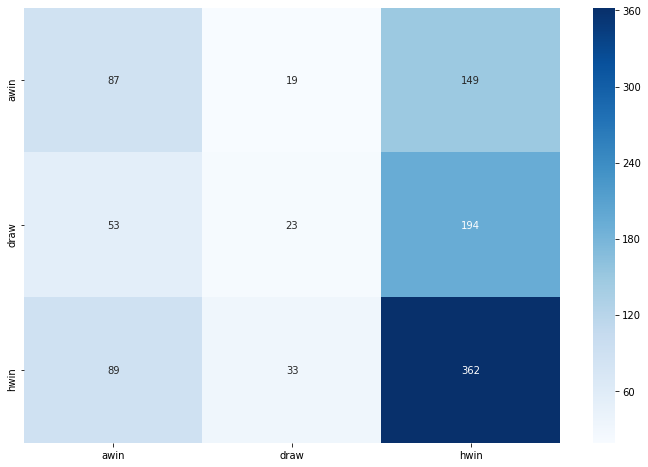

In [11]:
df_cm = pd.DataFrame(cm, cols, cols)
fig, ax = plt.subplots(figsize=(12,8))
#plt.figure(figsize = (12,8))
#sns.set(font_scale=1.0)#for label size
sns.heatmap(df_cm, annot=True,ax=ax, cmap='Blues', fmt='g')# font size

plt.show();

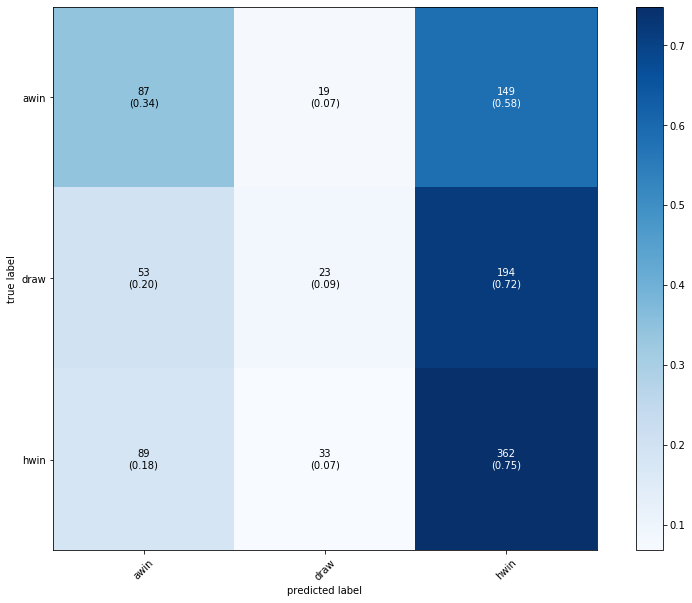

In [12]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=df_cm.values,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                               class_names=cols, figsize=(14,10))
plt.show();